In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import json
import copy

In [2]:
#  константы генетического алгоритма
POPULATION_SIZE = 50   # количество индивидуумов в популяции
MUTATION_RATE = 0.1    # Вероятность мутации
CROSSOVER_RATE = 0.9   # Вероятность кроссовера
MAX_GENERATIONS = 100    # максимальное количество поколений
NUM_PRODUCTS_PER_INDIVIDUAL = 30 # количество продуктов в одном рационе (индивид)

RANDOM_SEED = 43
random.seed(RANDOM_SEED)

In [3]:
#  Загрузка данных из products.json
with open('products.json', 'r', encoding='utf-8') as file:
    products = json.load(file)

parsed_products = []
for index, product in enumerate(products):
    # Разделение строки 'bgu' на отдельные значения (белки, жиры, углеводы)
    bgu_values = list(map(float, product['bgu'].split(',')))
    proteins, fats, carbs = bgu_values
    
    # Генерация случайной цены (от 10 до 200 условных единиц)
    price = random.randint(10, 200)
    
    # Создание нового объекта продукта
    parsed_product = {
        "index": index,
        "name": product["name"],
        "price": price,
        "proteins": proteins,
        "fats": fats,
        "carbs": carbs,
        "kcal": float(product["kcal"])
    }
    
    # Добавление продукта в новый список
    parsed_products.append(parsed_product)

# Вывод 5-ти элементов
for product in parsed_products[:5]:
    print(product)

{'index': 0, 'name': 'Абрикосы', 'price': 19, 'proteins': 0.9, 'fats': 0.1, 'carbs': 9.0, 'kcal': 44.0}
{'index': 1, 'name': 'Абрикос-ядро', 'price': 83, 'proteins': 25.0, 'fats': 45.4, 'carbs': 2.8, 'kcal': 519.1}
{'index': 2, 'name': 'Абрикосовое масло', 'price': 188, 'proteins': 0.0, 'fats': 99.9, 'carbs': 0.0, 'kcal': 899.1}
{'index': 3, 'name': 'Айва', 'price': 46, 'proteins': 0.6, 'fats': 0.5, 'carbs': 9.6, 'kcal': 48.0}
{'index': 4, 'name': 'Акула катран', 'price': 128, 'proteins': 19.9, 'fats': 7.0, 'carbs': 0.0, 'kcal': 143.0}


In [7]:
# Генерация случайной медицинской нормы БЖУ и калорий
def generate_medical_norm():
    proteins_norm = random.uniform(50, 150)  # Белки, граммы
    fats_norm = random.uniform(40, 90)       # Жиры, граммы
    carbs_norm = random.uniform(200, 400)    # Углеводы, граммы
    kcal_norm = random.uniform(1800, 2500)   # Калории, ккал
    print(proteins_norm)
    print(fats_norm)
    print(carbs_norm)
    print(kcal_norm)
    return {
        'proteins': proteins_norm,
        'fats': fats_norm,
        'carbs': carbs_norm,
        'kcal': kcal_norm
    }

def get_norm_range(medical_norm, tolerance=0.2):
    return {
        'proteins': (0.9 * medical_norm['proteins'], 1.1 * medical_norm['proteins']),
        'fats': (0.9 * medical_norm['fats'], 1.1 * medical_norm['fats']),
        'carbs': (0.9 * medical_norm['carbs'], 1.1 * medical_norm['carbs']),
        'kcal': (0.9 * medical_norm['kcal'], 1.1 * medical_norm['kcal'])
    }


medical_norm = generate_medical_norm()

# Получаем диапазоны норм для белков, жиров, углеводов и калорий
norm_ranges = get_norm_range(medical_norm)


122.31189046040416
66.83007668584676
335.46906895895154
2247.5200860092586


# Анализ продуктов в единичном экземплере относительно медицинской нормы

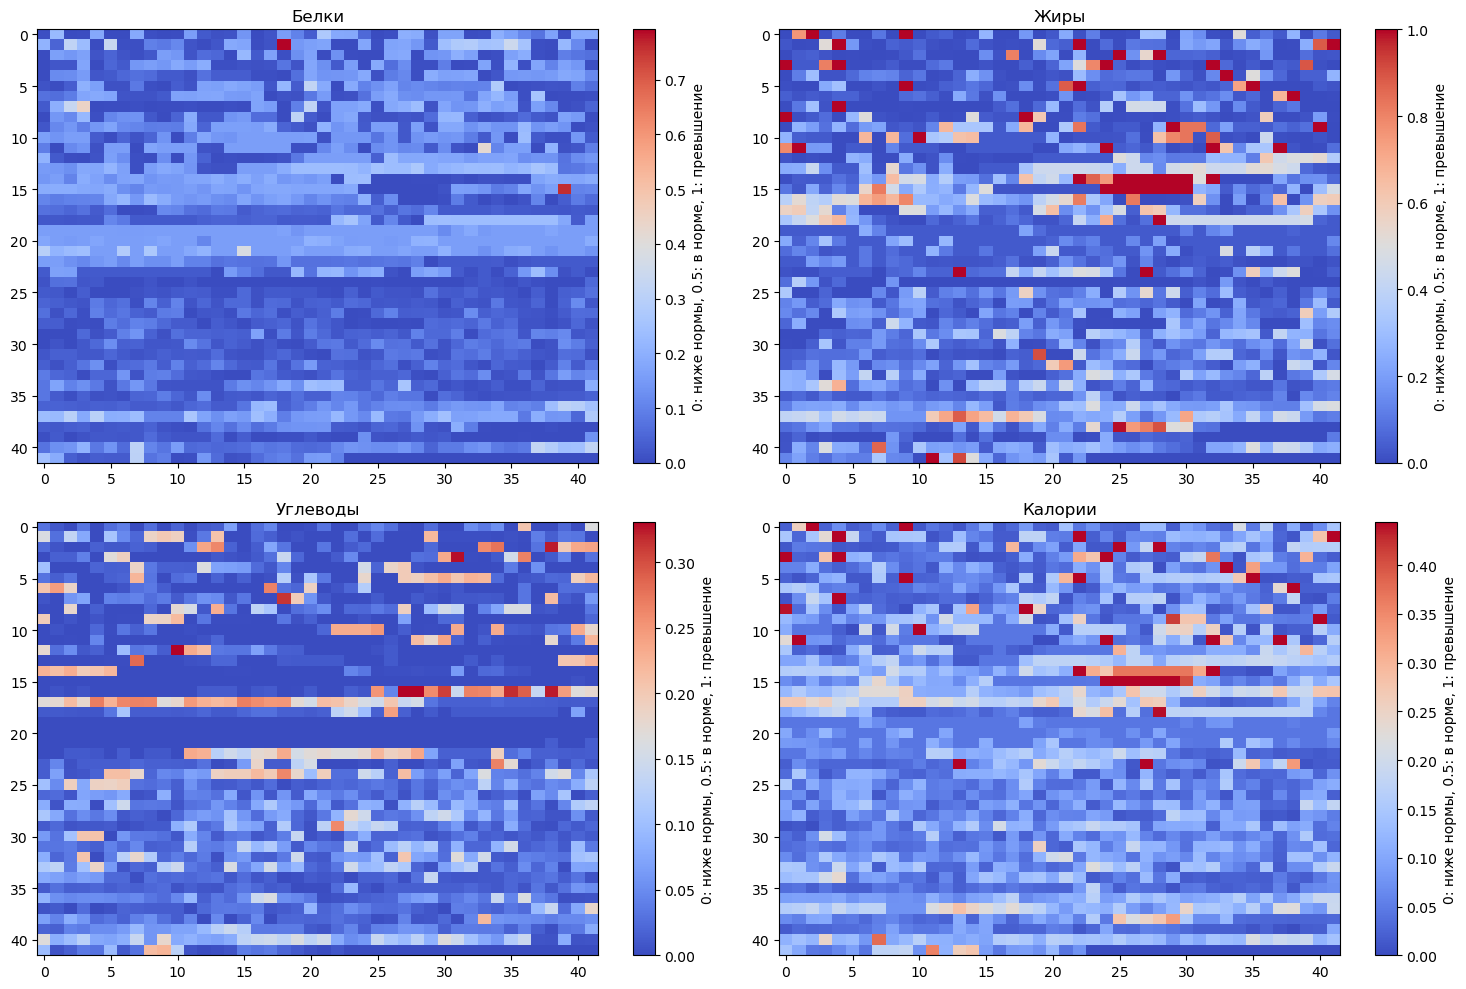

In [10]:
# Функция нормализации значений в диапазон от 0 до 1
def normalize_value(value, norm):
    # Если значение в норме ±10%, возвращаем 0.5
    if 0.9 * norm <= value <= 1.1 * norm:
        return 0.5
    # Если ниже нормы, нормализуем значение к 0
    elif value < 0.9 * norm:
        return max(0, value / (0.9 * norm))
    # Если выше нормы, нормализуем значение к 1
    else:
        return min(1, (value - norm) / (0.1 * norm) + 0.5)

# Создание матриц для каждого показателя с нормализацией значений
def create_matrix(parsed_products, norm_value, key):
    matrix = []
    for product in parsed_products:
        value = product[key]
        normalized_value = normalize_value(value, norm_value)
        matrix.append(normalized_value)
    return matrix

# Создание матриц для каждого показателя
proteins_matrix = create_matrix(parsed_products, medical_norm['proteins'], 'proteins')
fats_matrix = create_matrix(parsed_products, medical_norm['fats'], 'fats')
carbs_matrix = create_matrix(parsed_products, medical_norm['carbs'], 'carbs')
kcals_matrix = create_matrix(parsed_products, medical_norm['kcal'], 'kcal')

# Преобразование в двумерные матрицы для визуализации
num_products = len(parsed_products)
ROWS_COUNT = int(np.ceil(np.sqrt(num_products)))  # Количество строк для визуализации
COLUMNS_COUNT = ROWS_COUNT  # Количество столбцов для визуализации

proteins_matrix_2d = np.reshape(proteins_matrix + [0] * (ROWS_COUNT * COLUMNS_COUNT - len(proteins_matrix)), (ROWS_COUNT, COLUMNS_COUNT))
fats_matrix_2d = np.reshape(fats_matrix + [0] * (ROWS_COUNT * COLUMNS_COUNT - len(fats_matrix)), (ROWS_COUNT, COLUMNS_COUNT))
carbs_matrix_2d = np.reshape(carbs_matrix + [0] * (ROWS_COUNT * COLUMNS_COUNT - len(carbs_matrix)), (ROWS_COUNT, COLUMNS_COUNT))
kcals_matrix_2d = np.reshape(kcals_matrix + [0] * (ROWS_COUNT * COLUMNS_COUNT - len(kcals_matrix)), (ROWS_COUNT, COLUMNS_COUNT))

# Визуализация матриц
plt.figure(figsize=(15, 10))

# Матрица белков
plt.subplot(2, 2, 1)
plt.imshow(proteins_matrix_2d, cmap='coolwarm', aspect='auto')
plt.title('Белки')
plt.colorbar(label='0: ниже нормы, 0.5: в норме, 1: превышение')

# Матрица жиров
plt.subplot(2, 2, 2)
plt.imshow(fats_matrix_2d, cmap='coolwarm', aspect='auto')
plt.title('Жиры')
plt.colorbar(label='0: ниже нормы, 0.5: в норме, 1: превышение')

# Матрица углеводов
plt.subplot(2, 2, 3)
plt.imshow(carbs_matrix_2d, cmap='coolwarm', aspect='auto')
plt.title('Углеводы')
plt.colorbar(label='0: ниже нормы, 0.5: в норме, 1: превышение')

# Матрица калорий
plt.subplot(2, 2, 4)
plt.imshow(kcals_matrix_2d, cmap='coolwarm', aspect='auto')
plt.title('Калории')
plt.colorbar(label='0: ниже нормы, 0.5: в норме, 1: превышение')

plt.tight_layout()
plt.show()

Поколение 0: Макс. штраф = 12463.107173837858, Средний штраф = 41424.20801533128
Поколение 1: Макс. штраф = 9180.577173837859, Средний штраф = 28296.76491669904
Поколение 2: Макс. штраф = 9180.577173837859, Средний штраф = 19513.29433319587
Поколение 3: Макс. штраф = 7513.107173837856, Средний штраф = 11581.71859798301
Поколение 4: Макс. штраф = 4987.298119939707, Средний штраф = 9262.883002417955
Поколение 5: Макс. штраф = 4987.298119939707, Средний штраф = 7710.5790402620305
Поколение 6: Макс. штраф = 4987.298119939707, Средний штраф = 6673.3697819802655
Поколение 7: Макс. штраф = 4921.898119939708, Средний штраф = 5437.399492875263
Поколение 8: Макс. штраф = 4816.398119939708, Средний штраф = 4972.188317888556
Поколение 9: Макс. штраф = 4572.898119939708, Средний штраф = 4949.20789896652
Поколение 10: Макс. штраф = 4414.898119939707, Средний штраф = 4829.900317888557
Поколение 11: Макс. штраф = 4138.728963484022, Средний штраф = 4628.210168501216
Поколение 12: Макс. штраф = 3946.728

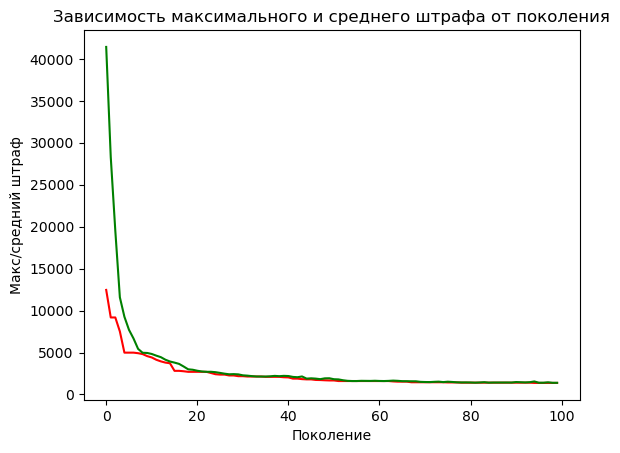

Лучший представитель:
Продукт: Глясе, Цена: 123, Белки: 1.9, Жиры: 4.1, Углеводы: 17.9, Ккал: 111.7
Продукт: Котлеты по-гречески, Цена: 62, Белки: 6.4, Жиры: 6.7, Углеводы: 24.6, Ккал: 178.1
Продукт: Перец красный сладкий, Цена: 21, Белки: 1.3, Жиры: 0.0, Углеводы: 5.7, Ккал: 26.6
Продукт: Казецит, Цена: 41, Белки: 3.0, Жиры: 5.0, Углеводы: 4.8, Ккал: 75.1
Продукт: Перец красный сладкий, Цена: 21, Белки: 1.3, Жиры: 0.0, Углеводы: 5.7, Ккал: 26.6
Продукт: Котлеты по-гречески, Цена: 62, Белки: 6.4, Жиры: 6.7, Углеводы: 24.6, Ккал: 178.1
Продукт: Перец красный сладкий, Цена: 21, Белки: 1.3, Жиры: 0.0, Углеводы: 5.7, Ккал: 26.6
Продукт: Мушмула, Цена: 49, Белки: 0.0, Жиры: 0.0, Углеводы: 14.0, Ккал: 52.5
Продукт: Язык морской, Цена: 57, Белки: 10.3, Жиры: 5.2, Углеводы: 0.0, Ккал: 88.0
Продукт: Мушмула, Цена: 49, Белки: 0.0, Жиры: 0.0, Углеводы: 14.0, Ккал: 52.5
Продукт: Мушмула, Цена: 49, Белки: 0.0, Жиры: 0.0, Углеводы: 14.0, Ккал: 52.5
Продукт: Перец красный сладкий, Цена: 21, Белки: 1.

In [16]:
# Генетический алгоритм
class GeneticAlgorithm:
    def __init__(self, products, norm_ranges):
        self.products = products
        self.norm_ranges = norm_ranges
        self.population = []
        self.max_fitness_values = []
        self.mean_fitness_values = []

    # Инициализация начальной популяции
    def initialize_population(self):
        self.population = []
        for _ in range(POPULATION_SIZE):
            if len(self.products) < NUM_PRODUCTS_PER_INDIVIDUAL:
                print("Недостаточно продуктов для создания популяции!")
                break
            individual = self.create_individual()
            self.population.append(individual)

    # Создание индивида с уникальным набором продуктов и удаление их из общего массива
    def create_individual(self):
        selected_products = random.sample(self.products, NUM_PRODUCTS_PER_INDIVIDUAL)
        for product in selected_products:
            self.products.remove(product)  # Удаляем выбранные продукты из общего массива
        return selected_products

    # Функция приспособленности: минимизировать стоимость продуктов, соответствующих нормам
    def fitness(self, individual):
        total_price = sum(product['price'] for product in individual)
        total_proteins = sum(product['proteins'] for product in individual)
        total_fats = sum(product['fats'] for product in individual)
        total_carbs = sum(product['carbs'] for product in individual)
        total_kcal = sum(product['kcal'] for product in individual)

        # Вычисление штрафов за несоответствие нормам
        penalties = 0
        if not (self.norm_ranges['proteins'][0] <= total_proteins <= self.norm_ranges['proteins'][1]):
            penalties += abs(total_proteins - self.norm_ranges['proteins'][1])  # Штраф за белки
        if not (self.norm_ranges['fats'][0] <= total_fats <= self.norm_ranges['fats'][1]):
            penalties += abs(total_fats - self.norm_ranges['fats'][1])  # Штраф за жиры
        if not (self.norm_ranges['carbs'][0] <= total_carbs <= self.norm_ranges['carbs'][1]):
            penalties += abs(total_carbs - self.norm_ranges['carbs'][1])  # Штраф за углеводы
        if not (self.norm_ranges['kcal'][0] <= total_kcal <= self.norm_ranges['kcal'][1]):
            penalties += abs(total_kcal - self.norm_ranges['kcal'][1])  # Штраф за калории

        # Приспособленность = стоимость + штрафы (чем ниже, тем лучше)
        return total_price + penalties * 10

    # Турнирный отбор
    def tournament_selection(self):
        tournament_size = 5
        tournament = random.sample(self.population, tournament_size)
        fittest_individual = min(tournament, key=self.fitness)
        return fittest_individual

    # Одноточечное скрещивание
    def crossover(self, parent1, parent2):
        if random.random() < CROSSOVER_RATE:
            crossover_point = random.randint(1, NUM_PRODUCTS_PER_INDIVIDUAL - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            return [child1, child2]
        return [parent1, parent2]

    # Двухточечное скрещивание
    def two_point_crossover(self, parent1, parent2):
        if random.random() < CROSSOVER_RATE:
            point1 = random.randint(1, NUM_PRODUCTS_PER_INDIVIDUAL - 2)
            point2 = random.randint(point1 + 1, NUM_PRODUCTS_PER_INDIVIDUAL - 1)
            child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
            child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]
            return [child1, child2]
        return [parent1, parent2]
    
    # k-точечное скрещивание
    # Указывай k для количества разрезов
    def k_point_crossover(self, parent1, parent2, k=3): 
        if random.random() < CROSSOVER_RATE:
            points = sorted(random.sample(range(1, NUM_PRODUCTS_PER_INDIVIDUAL), k))
            child1 = parent1[:points[0]] + parent2[points[0]:points[1]] + parent1[points[1]:points[2]] + parent2[points[2]:]
            child2 = parent2[:points[0]] + parent1[points[0]:points[1]] + parent2[points[1]:points[2]] + parent1[points[2]:]
            return [child1, child2]
        return [parent1, parent2]

    # Равномерное скрещивание
    def uniform_crossover(self, parent1, parent2):
        if random.random() < CROSSOVER_RATE:
            child1 = []
            child2 = []
            for i in range(NUM_PRODUCTS_PER_INDIVIDUAL):
                if random.random() < 0.5:
                    child1.append(parent1[i])
                    child2.append(parent2[i])
                else:
                    child1.append(parent2[i])
                    child2.append(parent1[i])
            return [child1, child2]
        return [parent1, parent2]
    
    # Мутация инвертированием
    def mutate(self, individual):
        if random.random() < MUTATION_RATE:
            mutation_index = random.randint(0, NUM_PRODUCTS_PER_INDIVIDUAL - 1)
            available_products = [p for p in self.products if p not in individual]
            if available_products:
                # Заменяем случайный продукт на другой
                individual[mutation_index] = random.choice(available_products)
        return individual

    # Мутация обменом
    def swap_mutation(self, individual):
        if random.random() < MUTATION_RATE:
            idx1, idx2 = random.sample(range(NUM_PRODUCTS_PER_INDIVIDUAL), 2)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        return individual

    # Мутация обращением
    def reverse_mutation(self, individual):
        if random.random() < MUTATION_RATE:
            start, end = sorted(random.sample(range(NUM_PRODUCTS_PER_INDIVIDUAL), 2))
            individual[start:end] = individual[start:end][::-1]
        return individual

    # Эволюция популяции
    def evolve_population(self):
        new_population = []

        # Сохранение лучших особей
        elite = sorted(self.population, key=self.fitness)[:2]
        new_population.extend(elite)

        # Создание новой популяции
        while len(new_population) < POPULATION_SIZE:
            parent1 = self.tournament_selection()
            parent2 = self.tournament_selection()

            #     crossover     two_point_crossover     k_point_crossover      uniform_crossover
            offspring = self.crossover(parent1, parent2) # Здесь меняй функции

            for child in offspring:

                #  mutate       swap_mutation        reverse_mutation
                mutated_child = self.swap_mutation(child) # Здесь меняй мутации

                new_population.append(mutated_child)
                if len(new_population) >= POPULATION_SIZE:
                    break

        self.population = new_population

    # Основной метод запуска генетического алгоритма
    def run(self):
        self.initialize_population()

        for generation in range(MAX_GENERATIONS):
            fitness_values = [self.fitness(individual) for individual in self.population]
            max_fitness = min(fitness_values)
            mean_fitness = np.mean(fitness_values)

            self.max_fitness_values.append(max_fitness)
            self.mean_fitness_values.append(mean_fitness)

            print(f"Поколение {generation}: Макс. штраф = {max_fitness}, Средний штраф = {mean_fitness}")

            self.evolve_population()
        
        # Графическое отображение результатов
        plt.plot(self.max_fitness_values, color='red')
        plt.plot(self.mean_fitness_values, color='green')
        plt.xlabel('Поколение')
        plt.ylabel('Макс/средний штраф')
        plt.title('Зависимость максимального и среднего штрафа от поколения')
        plt.show()

        # Находим лучшего представителя (индивидуума с наименьшей приспособленностью)
        best_individual = min(self.population, key=self.fitness)

        # Выводим информацию о лучшем представителе
        print("Лучший представитель:")
        for product in best_individual:
            print(f"Продукт: {product['name']}, Цена: {product['price']}, "
                f"Белки: {product['proteins']}, Жиры: {product['fats']}, "
                f"Углеводы: {product['carbs']}, Ккал: {product['kcal']}")

# Пример использования
copy_pd = copy.deepcopy(parsed_products)
ga = GeneticAlgorithm(copy_pd, norm_ranges)
ga.run()
